In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import math
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure', figsize=(14, 12))
from matplotlib import style
style.use('ggplot')
%matplotlib inline

import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [2]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 9, 1)

In [3]:
df = web.DataReader("MSFT", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-26,135.559998,133.899994,134.990005,135.449997,20312600.0,135.449997
2019-08-27,136.720001,134.660004,136.389999,135.740005,23102100.0,135.740005
2019-08-28,135.759995,133.550003,134.880005,135.559998,17393300.0,135.559998
2019-08-29,138.440002,136.910004,137.250000,138.119995,20168700.0,138.119995
2019-08-30,139.179993,136.270004,139.149994,137.860001,23940100.0,137.860001


In [4]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

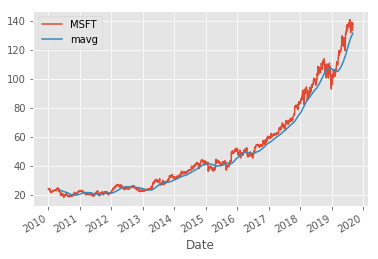

In [5]:
close_px.plot(label='MSFT')
mavg.plot(label='mavg')
plt.legend()

In [6]:
df1 = df.loc[:,['Adj Close','Volume']]
df1['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
df1['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [7]:
# Drop missing value
df1.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(df1)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
df1['label'] = df1[forecast_col].shift(-forecast_out)

In [8]:
X = np.array(df1.drop(['label'], 1))
X = scaler.fit_transform(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
y = np.array(df1['label'])
y = y[:-forecast_out]

In [9]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X,y)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X,y)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X,y)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X,y)

# Lasso Rigde
clflas = Lasso()
clflas.fit(X, y)

# Basesian Ridge
clfbyr = BayesianRidge()
clfbyr.fit(X, y)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [10]:
# confidence score
confidencereg = clfreg.score(X,y)
confidencepoly2 = clfpoly2.score(X,y)
confidencepoly3 = clfpoly3.score(X,y)
confidenceknn = clfknn.score(X,y)
confidencelas = clflas.score(X,y)
confidencebyr = clfbyr.score(X,y)

print('The linear regression confidence is ' + str(confidencereg))
print('The quadratic regression 2 confidence is ' + str(confidencepoly2))
print('The quadratic regression 3 confidence is ' + str(confidencepoly3))
print('The knn regression confidence is ' + str(confidenceknn))
print('The lasso regression confidence is ' + str(confidencelas))
print('The bayesian ridge confidence is ' + str(confidencebyr))

The linear regression confidence is 0.9912830201740129
The quadratic regression 2 confidence is 0.991379800057623
The quadratic regression 3 confidence is 0.9915639654991273
The knn regression confidence is 0.9925508866239263
The lasso regression confidence is 0.9901560519229909
The bayesian ridge confidence is 0.9912830198924973


In [11]:
# forecast prediction
forecast_reg = clfreg.predict(X_lately)
forecast_poly2 = clfpoly2.predict(X_lately)
forecast_poly3 = clfpoly3.predict(X_lately)
forecast_knn = clfknn.predict(X_lately)
forecast_las = clflas.predict(X_lately)
forecast_byr = clfbyr.predict(X_lately)

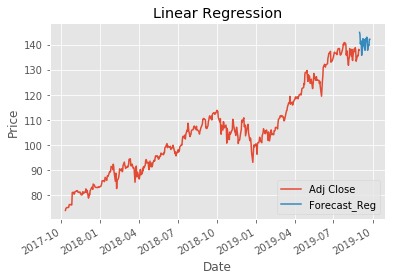

In [12]:
df1['Forecast_Reg'] = np.nan

last_date = df1.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_reg:
        next_date = next_unix
        next_unix += datetime.timedelta(days=1)
        df1.loc[next_date] = [np.nan for _ in range(len(df1.columns))]
        df1['Forecast_Reg'].loc[next_date] = i
df1['Adj Close'].tail(500).plot()
df1['Forecast_Reg'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Linear Regression')
plt.show()

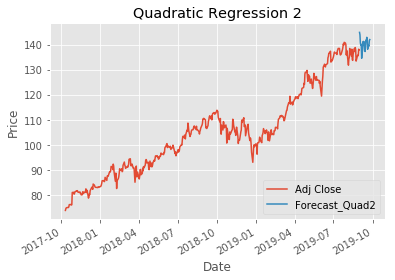

In [13]:
df1['Forecast_Quad2'] = np.nan

last_date = df1.iloc[-26].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_poly2:
        next_date = next_unix
        next_unix += datetime.timedelta(days=1)
        df1.loc[next_date] = [np.nan for _ in range(len(df1.columns))]
        df1['Forecast_Quad2'].loc[next_date] = i
df1['Adj Close'].tail(500).plot()
df1['Forecast_Quad2'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Quadratic Regression 2')
plt.show()

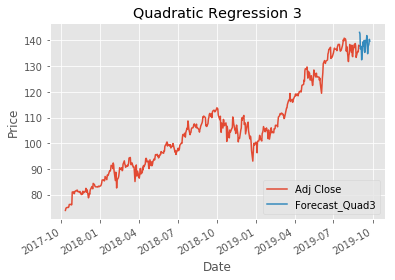

In [14]:
# quadratic regression 3
df1['Forecast_Quad3'] = np.nan

last_date = df1.iloc[-26].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_poly3:
        next_date = next_unix
        next_unix += datetime.timedelta(days=1)
        df1.loc[next_date] = [np.nan for _ in range(len(df1.columns))]
        df1['Forecast_Quad3'].loc[next_date] = i
df1['Adj Close'].tail(500).plot()
df1['Forecast_Quad3'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Quadratic Regression 3')
plt.show()

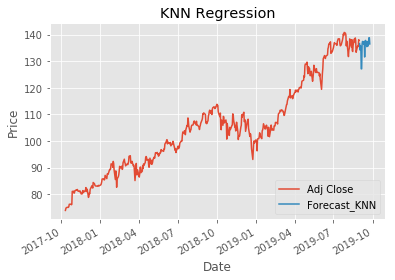

In [15]:
df1['Forecast_KNN'] = np.nan

last_date = df1.iloc[-26].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)
for i in forecast_knn:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    df1.loc[next_date] = [np.nan for _ in range(len(df1.columns))]
    df1['Forecast_KNN'].loc[next_date] = i
df1['Adj Close'].tail(500).plot()
df1['Forecast_KNN'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('KNN Regression')
plt.show()

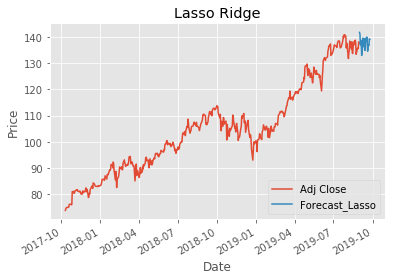

In [16]:
df1['Forecast_Lasso'] = np.nan

last_date = df1.iloc[-26].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)
for i in forecast_las:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    df1.loc[next_date] = [np.nan for _ in range(len(df1.columns))]
    df1['Forecast_Lasso'].loc[next_date] = i
df1['Adj Close'].tail(500).plot()
df1['Forecast_Lasso'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Lasso Ridge')
plt.show()

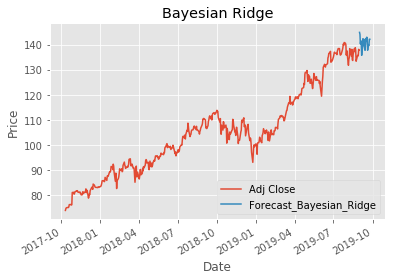

In [17]:
#%%
df1['Forecast_Bayesian_Ridge'] = np.nan

last_date = df1.iloc[-26].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)
for i in forecast_byr:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    df1.loc[next_date] = [np.nan for _ in range(len(df1.columns))]
    df1['Forecast_Bayesian_Ridge'].loc[next_date] = i
df1['Adj Close'].tail(500).plot()
df1['Forecast_Bayesian_Ridge'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bayesian Ridge')
plt.show()

#%%